# Bootstrap y Jackknife

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

plt.rc("figure", dpi=100)

In [2]:
def bootstrap_samples(statistic_func, samples, *, n_samples: int, shape=()):
    """Devuelve n_samples muestras de bootstrap para un dado estadístico."""
    rng = np.random.default_rng()

    out = np.empty((n_samples, *shape))
    for i in range(n_samples):
        resampled = rng.choice(samples, size=len(samples), replace=True, axis=0)
        out[i] = statistic_func(resampled)
    return out


def jackknife_samples(statistic_func, samples, *, shape=()):
    """Devuelve las muestras de jackknife para un dado estadístico."""
    out = np.empty((len(samples), *shape))
    for i in range(len(out)):
        subsample = np.delete(samples, i, axis=0)
        out[i] = statistic_func(subsample)
    return out


def bootstrap(statistic_func, samples, *, n_samples):
    """Realiza bootstrap para un dado estadístico.
    
    Devuelve el promedio, el bias y error del estadístico.
    """
    xm = statistic_func(samples)
    x = bootstrap_samples(statistic_func, samples, n_samples=n_samples, shape=xm.shape)
    mean = np.mean(x, axis=0)
    return {"mean": mean, "bias": mean - xm, "std": np.std(x, axis=0, ddof=1)}


def jackknife(statistic_func, samples):
    """Realiza jackknife para un dado estadístico.
    
    Devuelve el promedio, el bias y error del estadístico.
    """
    xm = statistic_func(samples)
    x = jackknife_samples(statistic_func, samples, shape=xm.shape)
    factor = samples.size - 1
    mean = np.mean(x, axis=0)
    return {
        "mean": mean,
        "bias": (mean - xm) * factor,
        "std": (np.var(x, axis=0) * factor) ** 0.5,
    }


## Promedio

Para estudiar el comportamiento de los métodos de bootstrap y jackknife, vamos a utilizar un caso donde conocemos el error del estadístico: el promedio.

Vamos a tomar 100 muestras de una distribucion normal $N(0, 1)$:

In [3]:
np.random.seed(42)

samples = np.random.normal(size=100)

Definimos la función `mean` para el estadistico y otra para el estimador para su error, y apliquemoslas al conjunto de muestras:

In [4]:
def mean(x):
    return np.mean(x)

def mean_error(x):
    return np.std(x, axis=0, ddof=1) / x.size**0.5

mean(samples), mean_error(samples)

(-0.10384651739409384, 0.09081684280078008)

Los valores esperados para estos estimadores son:

In [5]:
def true_mean(x):
    return 0

def true_mean_error(x):
    return 1 / x.size**0.5


true_mean(samples), true_mean_error(samples)

(0, 0.1)

Utilizando jacknife:

In [6]:
pd.Series(jackknife(mean, samples))

mean   -1.038465e-01
bias   -1.373901e-15
std     9.081684e-02
dtype: float64

llegamos al mismo valor para el estadístico y su error. El bias es nulo.

Por otro lado, con bootstrap:

In [7]:
pd.Series(bootstrap(mean, samples, n_samples=10_000))

mean   -0.105634
bias   -0.001788
std     0.091238
dtype: float64

llegamos a valores similares, aunque no exactamente iguales.

Comparemos todos juntos en una misma tabla:

In [8]:
pd.DataFrame(
    {
        "real": {"mean": true_mean(samples), "std": true_mean_error(samples)},
        "estimador": {"mean": mean(samples), "std": mean_error(samples)},
        "jackknife": jackknife(mean, samples),
        "bootstrap": bootstrap(mean, samples, n_samples=10_000),
    }
).round(4)

,real,estimador,jackknife,bootstrap
mean,0.0,-0.1038,-0.1038,-0.1041
std,0.1,0.0908,0.0908,0.0901
bias,NaN,NaN,-0.0000,-0.0002


### Evolución de Bootstrap en función del número de réplicas

Vamos a evaluar la evolución de los estimadores de bootstrap a medida que aumenta el número de réplicas. Para eso, vamos a ir calculando el promedio y la desviación estándar a medida que vamos agregando más muestras. Es decir, una especie de promedio cumulativo:

In [9]:
def cumulative_statistics(x):
    n = np.arange(1, x.size + 1)
    mean = np.cumsum(x) / n
    var = np.cumsum(x**2) / n - mean**2
    return pd.DataFrame({"n": n, "promedio": mean, "desv_est": np.sqrt(var)}).set_index("n")

Repetiremos esto múltiples veces, obteniendo una trayectoria distinta para cada promedio cumulativo:

100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


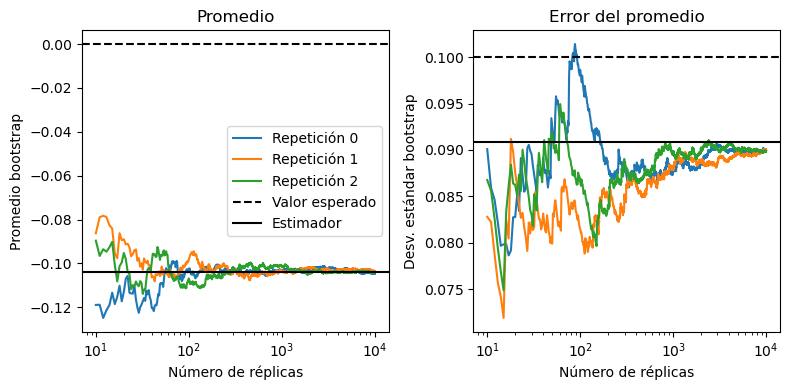

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)

for i in tqdm.trange(3):
    x = bootstrap_samples(mean, samples, n_samples=10_000)
    stats = cumulative_statistics(x).loc[10:]

    label = f"Repetición {i}"
    stats.promedio.rename(label).plot(ax=axes[0])
    stats.desv_est.rename(label).plot(ax=axes[1])

# Valores reales
axes[0].axhline(
    true_mean(samples), label="Valor esperado", color="k", linestyle="--"
)
axes[1].axhline(
    true_mean_error(samples),
    label="Valor esperado error",
    color="k",
    linestyle="--",
)

# Estimadores del promedio
axes[0].axhline(mean(samples), label="Estimador", color="k")
axes[1].axhline(mean_error(samples), label="Error estimador", color="k")

axes[0].set(
    title="Promedio",
    ylabel="Promedio bootstrap",
    xlabel="Número de réplicas",
    xscale="log",
)
axes[1].set(
    title="Error del promedio",
    ylabel="Desv. estándar bootstrap",
    xlabel="Número de réplicas",
    xscale="log",
)

axes[0].legend()


Las distintas curvas convergen al mismo valor que los estimadores para el promedio y su error (linea negra), aunque no a sus valores esperados (linea punteada), ya que solo se tiene una única realización del estimador.

Si repetimos más veces, podemos evaluar la distribución de estas trayectorias, para lo que graficamos los percentiles 25, 50 y 75 en función del número de réplicas:

100%|██████████| 100/100 [00:09<00:00, 10.22it/s]


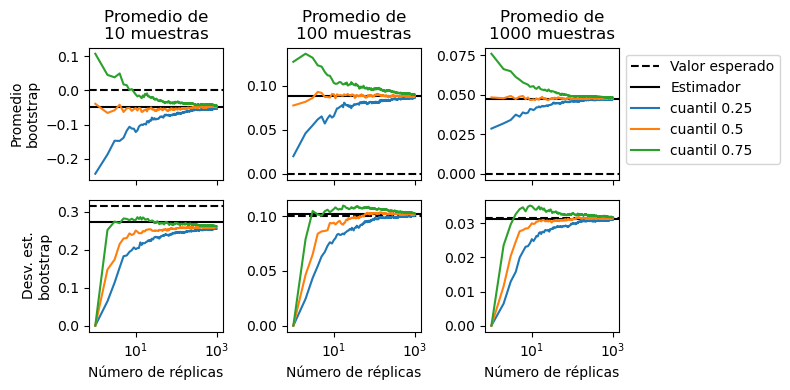

In [11]:
def plot(axes, samples, *, n_samples, n_exp):
    df = []
    for _ in tqdm.trange(n_exp):
        x = bootstrap_samples(mean, samples, n_samples=n_samples)
        df.append(cumulative_statistics(x))
    df = pd.concat(df, axis=1)

    # Valores reales
    axes[0].axhline(
        true_mean(samples), label="Valor esperado", color="k", linestyle="--"
    )
    axes[1].axhline(
        true_mean_error(samples),
        label="Valor esperado error",
        color="k",
        linestyle="--",
    )

    # Estimadores del promedio
    axes[0].axhline(mean(samples), label="Estimador", color="k")
    axes[1].axhline(mean_error(samples), label="Error estimador", color="k")

    # Estimadores de bootstrap
    for ax, cols in zip(axes, ("promedio", "desv_est")):
        df.filter(like=cols).quantile((0.25, 0.5, 0.75), axis=1).T.add_prefix(
            "cuantil "
        ).plot(ax=ax, legend=False)

    for ax in axes:
        ax.set(xlabel="Número de réplicas", xscale="log")


fig, axes = plt.subplots(2, 3, sharex="col", figsize=(8, 4), tight_layout=True)

axes[0, 0].set(ylabel="Promedio\nbootstrap")
axes[1, 0].set(ylabel="Desv. est.\nbootstrap")

for ax_col, n in zip(axes.T, (10, 100, 1000)):
    ax_col[0].set(title=f"Promedio de\n{n} muestras")
    plot(ax_col, samples=np.random.normal(size=n), n_samples=1_000, n_exp=100)

axes[0, -1].legend(bbox_to_anchor=(1, 1), loc="upper left")


Las curvas de bootstrap convergen a un mismo valor a medida que aumenta el número de muestras. Sin embargo, el valor al que convergen parece subestimar el error del estimador cuando la cantidad de muestras de la distribución original es baja (gráfico de la primer columna, segunda fila).

## Fotones

Cargamos el dataset de número de fotones en función del ángulo.

In [12]:
fotones = np.loadtxt("fotones36.txt", usecols=1)

Definimos una función que devuelve el coeficiente de correlación entre dos vectores, y otra función que rota las observaciones de fotones:

In [13]:
def correlate(data):
    x, y = data.T
    return np.corrcoef(x, y)[0,1]

def shifted(x, shift):
    out = np.empty((x.size, 2))
    out[:,0] = x
    out[:,1] = np.roll(x, shift)
    return out

Para `shift=0`, la correlación es 1:

In [14]:
correlate(shifted(fotones, shift=0))


1.0

Si gráficamos la correlación en función del `shift`:

[Text(0.5, 0, 'Ángulo [°]'), Text(0, 0.5, 'Correlación')]

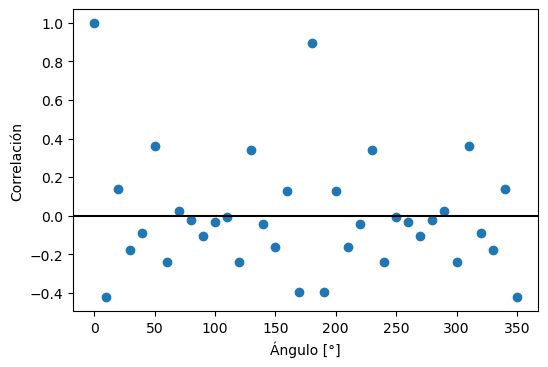

In [15]:
shifts = np.arange(fotones.size)
angles = 10 * shifts

fig, ax = plt.subplots()
ax.scatter(angles, [correlate(shifted(fotones, shift=s)) for s in shifts])
ax.axhline(0, color="k")
ax.set(xlabel="Ángulo [°]", ylabel="Correlación")


Para tener una estimación del error de la correlación, y determinar si la correlación a 180° es realmente distinta de 0, podemos usar los métodos de Jackknife y Bootstrap:

In [16]:
df_jackknife = pd.DataFrame([jackknife(correlate, shifted(fotones, s)) for s in shifts])
df_jackknife["angle"] = angles

df_bootstrap = pd.DataFrame([bootstrap(correlate, shifted(fotones, s), n_samples=1_000) for s in tqdm.tqdm(shifts)])
df_bootstrap["angle"] = angles

100%|██████████| 36/36 [00:08<00:00,  4.02it/s]


[Text(0.5, 0, 'Angulo [°]'), Text(0, 0.5, 'Correlación')]

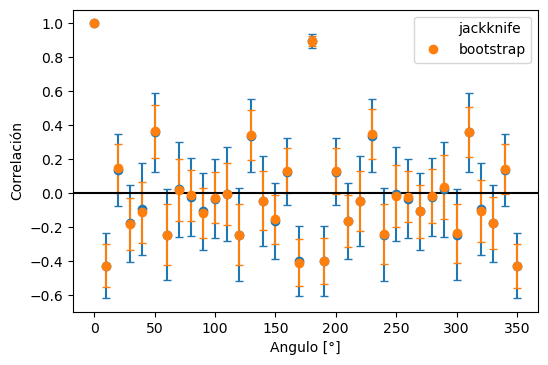

In [17]:
fig, ax = plt.subplots()

for label, df in {"jackknife": df_jackknife, "bootstrap": df_bootstrap}.items():
    df.plot(x="angle", y="mean", yerr="std", fmt="o", capsize=3, label=label, ax=ax)

ax.axhline(0, color="k")
ax.set(xlabel="Angulo [°]", ylabel="Correlación")

La correlación a 180° es definitivamente distinta de 0, estando a casi 30 sigmas de distancia de este:

In [18]:
p_180 = df_bootstrap.set_index("angle").loc[180]

p_180["mean"] / p_180["std"]

29.250026811338277